In [1]:
import numpy as np # for linear algebra
import scipy.stats # for distributions generation 
from scipy.optimize import minimize, least_squares # optimizers
import matplotlib.pyplot as plt # for graphs
import pandas as pd # for dataframes
import statsmodels.api as sm # for adding a constant in the equation
import seaborn as sns # for histograms
from tqdm import tqdm # time for cycle

import warnings
warnings.simplefilter("ignore")

# Task 1

## Hansen 23.10

### (a)

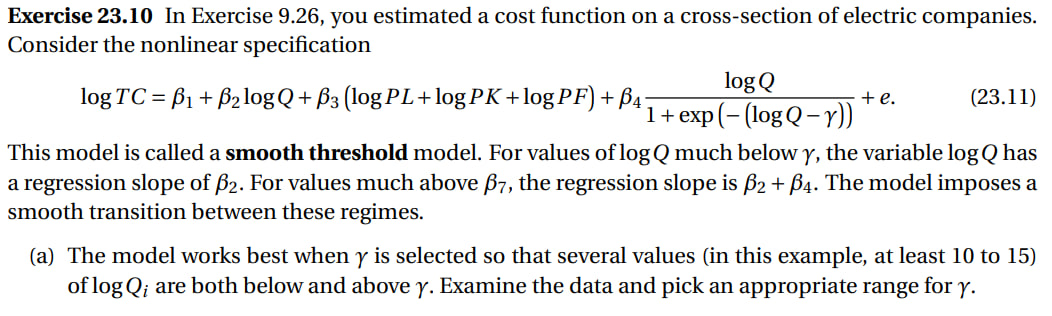

In [2]:
# illustration
from IPython.display import Image
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA4/H_23_10_a.jpg'
Image(filename=image_path)

Import data

Link: https://users.ssc.wisc.edu/~bhansen/econometrics/

In [3]:
CD_df = pd.read_excel('Nerlove1963.xlsx').apply(np.log)
CD_df.head(3)

,Cost,output,Plabor,Pcapital,Pfuel
0,-2.501036,0.693147,0.737164,5.209486,2.884801
1,-0.414001,1.098612,0.717840,5.159055,3.558201
2,-0.010050,1.386294,0.717840,5.141664,3.558201


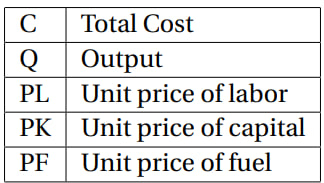

In [4]:
# illustration
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA2/table.jpg'
Image(filename=image_path)

Rename dataset by the names in te task.

In [5]:
CD_df.rename(columns={'Cost': 'logTC', 'output': 'logQ', 'Plabor': 'logPL', 'Pcapital': 'logPK', 'Pfuel': 'logPF'}, inplace=True)
CD_df['LogPL_LogPC_LogPF'] = CD_df['logPL'] + CD_df['logPK'] + CD_df['logPF']
CD_df.head(3)

,logTC,logQ,logPL,logPK,logPF,LogPL_LogPC_LogPF
0,-2.501036,0.693147,0.737164,5.209486,2.884801,8.831451
1,-0.414001,1.098612,0.717840,5.159055,3.558201,9.435096
2,-0.010050,1.386294,0.717840,5.141664,3.558201,9.417704


Plot the distribution of logQ.

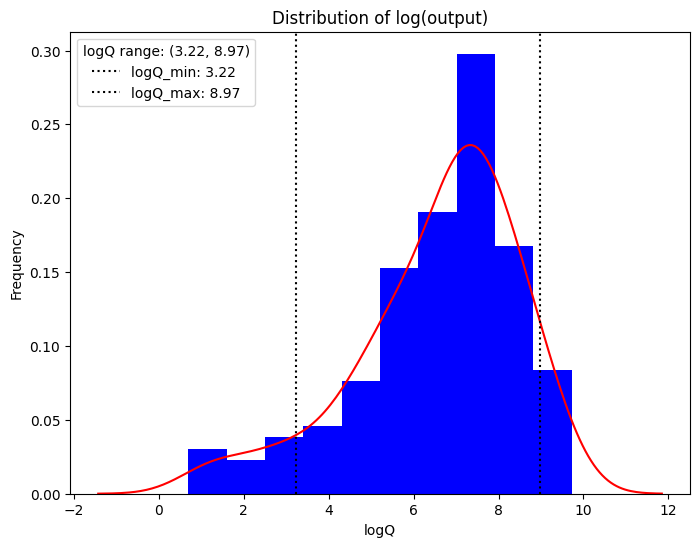

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(x = CD_df['logQ'], bins=10, color='red', kde=True, hist=True, hist_kws={'color': 'blue', 'alpha': 1})
# labels and title
ax.set_xlabel('logQ')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of log(output)')

#logQ range values - get 10 top and bottom logQ out
logQ_min = round(CD_df['logQ'].sort_values().values[10], 2)
logQ_max = round(CD_df['logQ'].sort_values().values[-10], 2)

# Annotate 
ax.axvline(x=logQ_min, color='black', linestyle=':', label=f"logQ_min: {logQ_min}")
ax.axvline(x=logQ_max, color='black', linestyle=':', label=f"logQ_max: {logQ_max}")
plt.legend(title=f"logQ range: ({logQ_min}, {logQ_max})")

plt.show()

### (c)

Estimate the model by NLLS using a concentrated numerical search over γ.

Let's estimate $\gamma$ by  using concentration method: for each value of the grid
$\gamma$ estimate standard OLS and SSR; we are interested in the $\gamma$ which minimizes SSR.

In [7]:
# to det all the functions to compute betas and standard errors
import sys

path = 'C:/Users/Popov/Documents/NES_studies/Python/NES_Helper' # Местоположение файла на диске
sys.path.append(path)

from NES_helper import Estimators as est

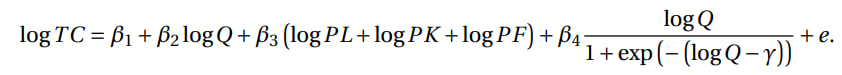

In [8]:
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA4/Regression.jpg'
Image(filename=image_path)

In [9]:
# set the grid for our seeked parameter
Gamma_grid=np.linspace(logQ_min,logQ_max,10**4)
# Store values of coefficients and least squares estimate
b1_val=np.zeros(len(Gamma_grid))
b2_val=np.zeros(len(Gamma_grid))
b3_val=np.zeros(len(Gamma_grid))
b4_val=np.zeros(len(Gamma_grid))
SSR=np.zeros(len(Gamma_grid))

# Compute OLS for each value of G_grid
for i in tqdm(range(len(Gamma_grid))):
    Gamma=Gamma_grid[i] # just notation for the running value of gamma
    QuasiReg= CD_df['logQ']/(1 + np.exp(-(CD_df['logQ']-Gamma)))# quasiregressor for beta_4
    ones = np.ones(len(CD_df['logQ'])) # intercept
    X = np.array((ones, CD_df['logQ'], CD_df['LogPL_LogPC_LogPF'], QuasiReg)).T # matrix of quasiregressor values
    Y = np.array((CD_df['logTC']))[:, np.newaxis]
    esti = est(X, Y)
    beta_hat = esti.beta_est() # get beta vector
    # # to get separate betas
    # for i, b_val in enumerate(beta_hat, start=1):
    #     exec(f"b{i}_val = b_val")
    esti.betas_ind(beta_hat)
    # store the coefficients
    b1_val[i] = esti.b1_hat
    b2_val[i] = esti.b2_hat
    b3_val[i] = esti.b3_hat
    b4_val[i] = esti.b4_hat
    # get and store SSR
    SSR[i]=np.sum((Y.flatten()-esti.b1_hat-esti.b2_hat*CD_df['logQ']-\
                  esti.b3_hat*CD_df['LogPL_LogPC_LogPF']-esti.b4_hat*QuasiReg)**2) # storing least squares values

100%|██████████| 10000/10000 [00:07<00:00, 1422.22it/s]


Sum of Squared Residuals (SSR)

In [10]:
SSR[0:5]

array([22.04846076, 22.04901268, 22.04956229, 22.05010959, 22.05065458])

In [11]:
# chose the case with the least SSR
min_SRR=np.argmin(SSR)
# bet coefficients for it
beta_1 = b1_val[min_SRR]
beta_2 = b2_val[min_SRR]
beta_3 = b3_val[min_SRR]
beta_4 = b4_val[min_SRR]
gamma = Gamma_grid[min_SRR]

print(f'beta_{1}: {beta_1:.2f}')
print(f'beta_{2}: {beta_2:.2f}')
print(f'beta_{3}: {beta_3:.2f}')
print(f'beta_{4}: {beta_4:.2f}')
print(f'gamma: {gamma:.2f}')

beta_1: -5.32
beta_2: 0.44
beta_3: 0.37
beta_4: 0.22
gamma: 6.88


### (d)

Calculate standard errors for all the parameters estimates (β1,β2,β3,β4,γ).

Compute standard errors using OLS formilas and the notion of a quasi-regressor:
$$ g_\beta(x, b) = \frac{\partial g(x, b)}{\partial b}, \quad Q_{gg} = E[g_\beta(x, \beta) g_\beta(x, \beta)'], \quad V_{ge} = \text{Var}[g_\beta  e] = E[g_\beta  g_\beta' e^2] $$
$$ V_\beta = Q_{gg}^{-1} V_{ge} Q_{gg}^{-1} $$

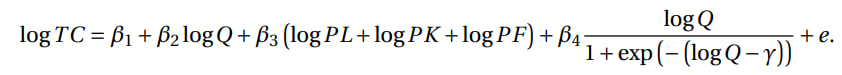

In [36]:
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA4/Regression.jpg'
Image(filename=image_path)

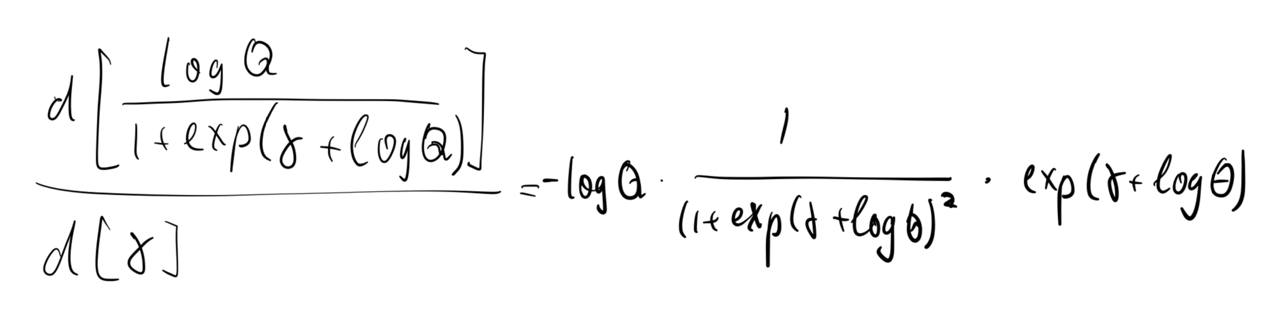

In [37]:
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA4/Gamma_grad.jpg'
Image(filename=image_path)

In [38]:
# the problem nonlinear models is that there is no need for class- calculations are unique for each model
def get_y_hat(X, Betas): # (n,)
    # b[:-2] = {beta_1-3}
    # b[-2] = {beta_4}
    # b[-1] = gamma
    return (X @ Betas[:-2] + Betas[-2] * (X[:, 1]/(1+np.exp(-(X[:, 1]-Betas[-1])))))[:, np.newaxis]

def get_residuals(Betas):
    return Y - get_y_hat(X_l, Betas)

def get_y_grad(X, Betas): # the vector of quasiregressors
    return np.array([
        X[:, 0], # derivative by beta_1
        X[:, 1], # derivative by beta_2
        X[:, 2], # derivative by beta_3
        X[:, 1]/(1+np.exp(-(X[:, 1]-Betas[-1]))), # derivative by beta_4 (aww rhw pixture comment above)
        -(Betas[-2]*X[:, 1]*np.exp(-(X[:, 1]-Betas[-1])))*((1+np.exp(-(X[:, 1]-Betas[-1]))) ** (-2))]).T

def get_residuals_jac(Betas): # (n, 3)
    return -get_y_grad(X, Betas)

In [39]:
Coefs_hat = np.array([beta_1, beta_2, beta_3, beta_4, gamma])

Let's compute the vector of quasiregressors: $$ g_\beta(x, b) = \frac{\partial g(x, b)}{\partial b}$$

In [40]:
# without specifying any parameters - only data
X_l = np.array((ones, CD_df['logQ'], CD_df['LogPL_LogPC_LogPF'])).T

# all required (optimal) parameters
betas_opt = [beta_1, beta_2, beta_3, beta_4, gamma]

g = get_y_grad(X_l, betas_opt)
g.shape

(145, 5)

$$\quad Q_{gg} = E[g_\beta(x, \beta)' g_\beta(x, \beta)]$$

Sample analogue:

$$ \sum_{i=1}^{n}\frac{1}{n}\hat{g}_\beta(x, \beta)' \hat{g}_\beta(x, \beta)$$

In [41]:
n = X_l.shape[0]
Qgg = g.T @ g / n
print(n, Qgg.shape)

145 (5, 5)


$$\quad V_{ge} = \text{Var}[g_\beta  e] = E[g_\beta'  g_\beta e^2]$$

Sample analogue:

$$ \sum_{i=1}^{n}\frac{1}{n}\hat{g}_\beta(x, \beta)' \hat{g}_\beta(x, \beta)'e^2$$

In [42]:
Er2 = get_residuals(betas_opt) ** 2

Omega = np.diag(Er2.reshape(n))

Vge = (g.T @ Omega @ g)/ n

Vb = np.linalg.inv(Qgg) @ Vge @ np.linalg.inv(Qgg)

for i in range(4):
    beta_value = Coefs_hat[i]
    standard_error = np.diag(Vb / n)[i] ** 0.5
    print(f'Beta {i+1}: {beta_value:.2f} ({standard_error:.2f})')

gamma_value = Coefs_hat[4]
gamma_standard_error = np.diag(Vb / n)[4] ** 0.5
print(f'Gamma: {gamma_value:.2f} ({gamma_standard_error:.2f})')

Beta 1: -5.32 (0.49)
Beta 2: 0.44 (0.10)
Beta 3: 0.37 (0.04)
Beta 4: 0.22 (0.05)
Gamma: 6.88 (0.36)


##  b)

Now, instead of using the concentration method, use general smooth optimization in
Python. Perform both point NLLS estimation and computation of NLLS standard errors. Try several starting parameter combinations. Did the two methods yield identical
results? Which method turned out more reliable and/or convenient?

In [128]:
# we wil have to do same operations over and over again, so, let's define functions
# for everything we have to do 
X_l = np.array((ones, CD_df['logQ'], CD_df['LogPL_LogPC_LogPF'])).T

def get_resid(Betas): # now in a list type
    return (Y - get_y_hat(X_l, Betas)).ravel()
    
def NLLS(Start_param):
    # get optimal parameters
    result = least_squares(
    fun=get_resid,
    x0=Start_param,
    jac=get_resid_jac)
    # output - result.x - optimal coefficients
    
    # get standard errors
    n=X_l.shape[0]
    g = get_y_grad(X_l, result.x)
    Qgg = g.T @ g / n
    Er2 = get_residuals(betas_opt) ** 2
    Omega = np.diag(Er2.reshape(n))
    Vge = (g.T @ Omega @ g)/ n
    Vb = np.linalg.inv(Qgg) @ Vge @ np.linalg.inv(Qgg)
    
    print(f'Starting coefficients: {Start_param}')
    for i in range(4):
        beta_value = result.x[i]
        standard_error = np.diag(Vb / n)[i] ** 0.5
        print(f'Beta {i+1}: {beta_value:.2f} ({standard_error:.2f})')
    
    gamma_value = result.x[4]
    gamma_standard_error = np.diag(Vb / n)[4] ** 0.5
    print(f'Gamma: {gamma_value:.2f} ({gamma_standard_error:.2f})')
    # return result.x, Vb

In [131]:
# fow some starting parameters - same results
NLLS([0, 0, 0, 0, 4])

Starting coefficients: [0, 0, 0, 0, 4]
Beta 1: -5.32 (0.49)
Beta 2: 0.44 (0.10)
Beta 3: 0.37 (0.04)
Beta 4: 0.22 (0.05)
Gamma: 6.87 (0.36)


In [133]:
# starting parameters for which the result differs
NLLS([0, 0, 0, 0, 1])

Starting coefficients: [0, 0, 0, 0, 1]
Beta 1: -7.65 (0.50)
Beta 2: 16.34 (35.94)
Beta 3: 0.34 (0.04)
Beta 4: -15.42 (35.96)
Gamma: -0.78 (2.62)


## c)

Compute the average (over observations) marginal influence of the variable logQ on
the conditional mean of log TC; and the marginal influence of the variable logQ on
the conditional mean of log TC evaluated at the sample means of the regressors. How
much different are the two measures?


In [119]:
def NLLS_get_result(Start_param):
    # get optimal parameters
    result = least_squares(
    fun=get_resid,
    x0=Start_param,
    jac=get_resid_jac)
    # output - result.x - optimal coefficients
    
    # get standard errors
    n=X_l.shape[0]
    g = get_y_grad(X_l, result.x)
    Qgg = g.T @ g / n
    Er2 = get_residuals(betas_opt) ** 2
    Omega = np.diag(Er2.reshape(n))
    Vge = (g.T @ Omega @ g)/ n
    Vb = np.linalg.inv(Qgg) @ Vge @ np.linalg.inv(Qgg)
    
    return result.x

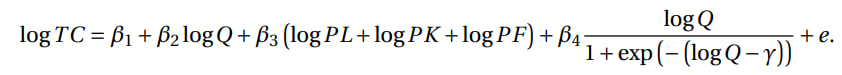

In [109]:
# recall
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA4/Regression.jpg'
Image(filename=image_path)

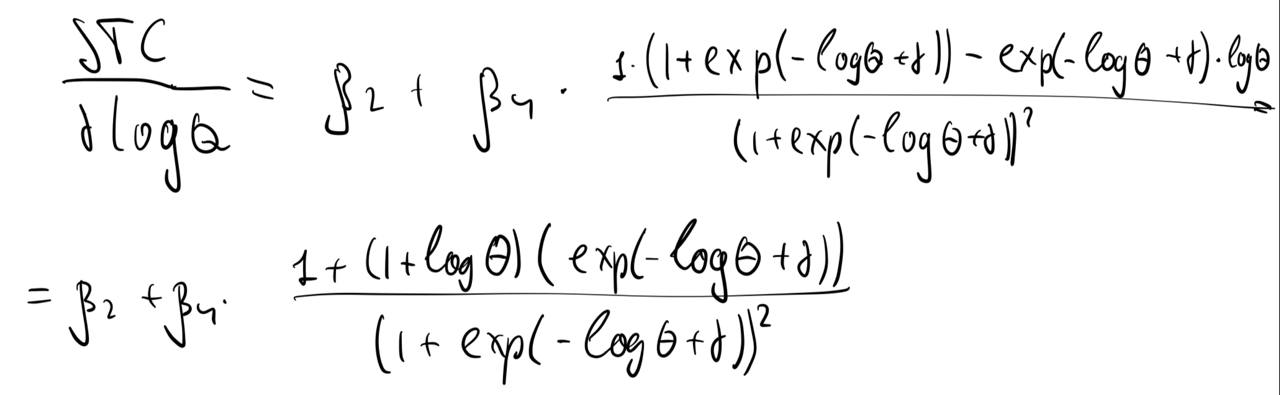

In [110]:
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA4/ME_logq.jpg'
Image(filename=image_path)

In [135]:
def ME_logQ(logQ, Betas):
      return Betas[1] + Betas[-2] * ((1+(1+logQ)*np.exp(-(logQ-Betas[-1])))/((1+np.exp(-(logQ-Betas[-1]))) ** 2))

In [140]:
logq = X_l[:,1]
betas = NLLS_get_result([0, 0, 0, 0, 4])

[-5.32108396  0.43777406  0.37074122  0.22402059  6.87494637]


In [141]:
ME_TC = ME_logQ(logq, betas)
print(f'Average marginal effect is: {ME_TC.mean():.2f}')

Average marginal effect is: 0.80


In [138]:
print(f'Marginal effect evaluated at average: {ME_logQ(logq.mean(),betas):.2f}')

Marginal effect evaluated at average: 0.89


Of course they differ.